In [235]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Preprocessing Data

In [135]:
train = pd.read_csv('data/heart_train.csv')
val = pd.read_csv('data/heart_val.csv')
test = pd.read_csv('data/heart_test.csv')

target_variable = "HeartDisease"

continuous_features = list(train._get_numeric_data().columns)
categorical_features = list(set(train.columns) - set(continuous_features) - set([target_variable]))

In [153]:
def data_preprocessing(data: pd.DataFrame, categorical_features: List[str], continuous_features: List[str], target_variable: str):

    df = data.copy()

    # protected variables
    sex = df["Sex"].values
    age = df["AgeCategory"].values
    race = df["Race"].values

    # target
    target = df[target_variable].values

    df_processed = df[categorical_features + continuous_features]
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_',
                                  dummy_na=False, columns=categorical_features, drop_first=True)

    return df_processed, df, target, sex, age, race


train_processed, train_original, train_target, train_sex, train_age, train_race = data_preprocessing(
    train, categorical_features=categorical_features, continuous_features=continuous_features, target_variable=target_variable)

val_processed, val_original, val_target, val_sex, val_age, val_race = data_preprocessing(
    val, categorical_features=categorical_features, continuous_features=continuous_features, target_variable=target_variable)

# Equalized odds with roc curves

### Model

In [323]:
scaler = ColumnTransformer(
    [('scaler', StandardScaler(), continuous_features)], remainder='passthrough')

whitebox_model = Pipeline(steps=[('scaler', scaler), ('clf', LogisticRegression(max_iter=10000))])

whitebox_model.fit(train_processed, train_target)
y_pred_whitebox = whitebox_model.predict(val_processed)
y_pred_proba_whitebox = whitebox_model.predict_proba(val_processed)

print(classification_report(val_target, y_pred_whitebox))

              precision    recall  f1-score   support

          No       0.92      0.99      0.96     43863
         Yes       0.55      0.11      0.19      4106

    accuracy                           0.92     47969
   macro avg       0.74      0.55      0.57     47969
weighted avg       0.89      0.92      0.89     47969



### Roc curve


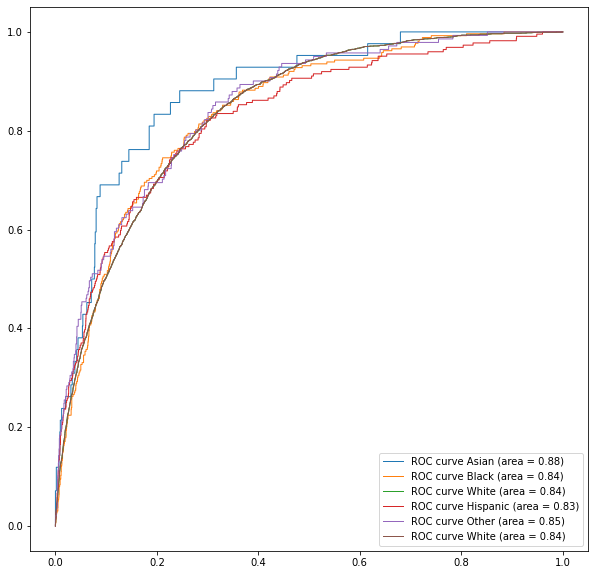

In [324]:
races = ["Asian", "Black", "White", "Hispanic", "Other", "White"]

fix, ax = plt.subplots(figsize=(10,10))

for race in races:
    y_score = y_pred_proba_whitebox[val_processed["Race_"+race]==1]
    fpr, tpr, threshold = roc_curve(val_target[val_processed["Race_"+race]==1], y_score[:, 1], drop_intermediate=False, pos_label="Yes")
    roc_auc = auc(fpr, tpr)
    
    ax.plot(
        fpr,
        tpr,
        lw=1,
        label=f"ROC curve {race} (area = %0.2f)" % roc_auc)
plt.legend()

In [325]:
def equalized_odds(preds, groups, test):
    df = pd.DataFrame(list(zip(preds, groups, test)), columns=['preds', 'groups', 'test'])
    targets = df['test'].unique()
    groups = df['groups'].unique()
    labels = []
    y = []
    
    for target in targets:
        temp_labels = []
        temp_y = []
        for group in groups:
            selection = df.loc[(df['test'] == target) & (df['groups'] == group)]
            corrects = selection.loc[selection['preds'] == target]
            score = round(len(corrects) / len(selection), 3)
            temp_labels.append(f'T: {target}, G: {group}')
            temp_y.append(score)
        labels.append(temp_labels)
        y.append(temp_y)
    

    
    # PLOTTING
    fig, ax = plt.subplots(figsize=(8,6), sharey=False)
    
    x = np.arange(len(groups))  # the label locations
    width = 0.35
    
    rects1 = ax.bar(x - width/2, y[0], width, label='Yes')
    rects2 = ax.bar(x + width/2, y[1], width, label='No')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Score')
    ax.set_title('Scores by group and target')
    ax.set_xticks(x, groups)
    ax.legend()
    
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()
    plt.show()

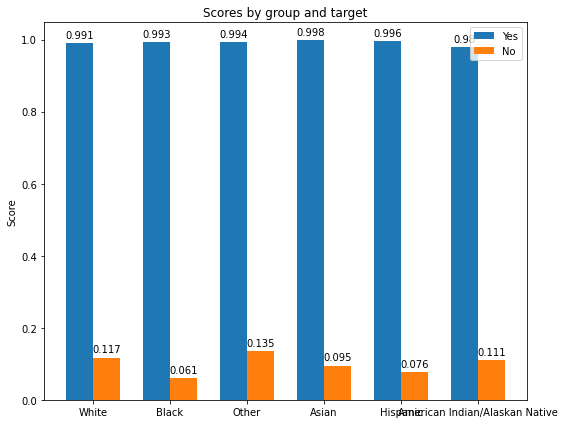

In [326]:
equalized_odds(y_pred_whitebox, val_race, val_target)